In [1]:
import pathlib
import numpy as np

from fytok.Tokamak import Tokamak
from spdm.view import View as sp_view
from spdm.data.Path import Path

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

2023-12-27 07:31:18,246 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-27T07:31:18.016042.
 Job ID: fytok_salmon_surface_7140

###################################################################################################



In [2]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.01, 0.999, 128)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            {"code": {"name": "collisional_equipartition"}},
            {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"]}}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "current_diffusion": True,
                "rho_tor_norm": np.linspace(0.01, 0.999, 128),
                "bvp_rms_mask": [0.96],
                "hyper_diff": 0.0001,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "normalize_units": {
                    "*|density": 1.0e21,
                    "*|density_flux": 1.0e24,
                    "ion|alpha|density": 1.0e18,
                    "ion|alpha|density_flux": 1.0e21,
                    "*|temperature": 1.0e6,
                    "*|temperature_flux": 1.0e27,
                },
            },
        },
        "ion_thermal": ["D", "T"],
        "ion_non_thermal": ["alpha", "He"],
        "impurities": ["Ar", "Be"],
        "boundary_condition": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*|density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*|temperature"             : 1,
            # fmt: on
        },
    },
)

2023-12-27 07:31:18,433 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2023-12-27 07:31:18,586 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-12-27 07:31:18,637 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.transport_solver.refresh(
    time=0.0,
    # fmt:off
    initial_value={
        "psi":0.0,
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   1.0,
        "ion/alpha/density":                1.0,

        "ion/D/temperature":                2.0e3,
        "ion/T/temperature":                2.0e3,
        "ion/He/temperature":               2.0e3,
        "electrons/temperature":            2.0e3,
    },
    boundary_value={
        "ion/D/density":                    1.3e19, 
        "ion/T/density":                    1.3e19, 
        "ion/He/density":                   1.0, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)
solver_1d = tokamak.transport_solver.time_slice.current

2023-12-27 07:31:18,677 [    spdm]     INFO: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-12-27 07:31:19,003 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-27 07:31:19,007 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-27 07:31:19,013 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-27 07:31:19,018 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-27 07:31:19,024 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-27 07:31:19,029 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.fy_eq 
2023-12-27 07:31:19,038 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-27 07:31:19,043 [    spdm]     INFO: Initialize module fytok.modules.CoreTransport 
2023-12-27 07:31:19,047 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2023-12-27 07:31:19,050 [    spdm]     INFO: Initialize module fytok.plugins.transport_solver_num

2023-12-27 07:31:24,315 [    spdm]     INFO: Load module spdm.view.view_matplotlib


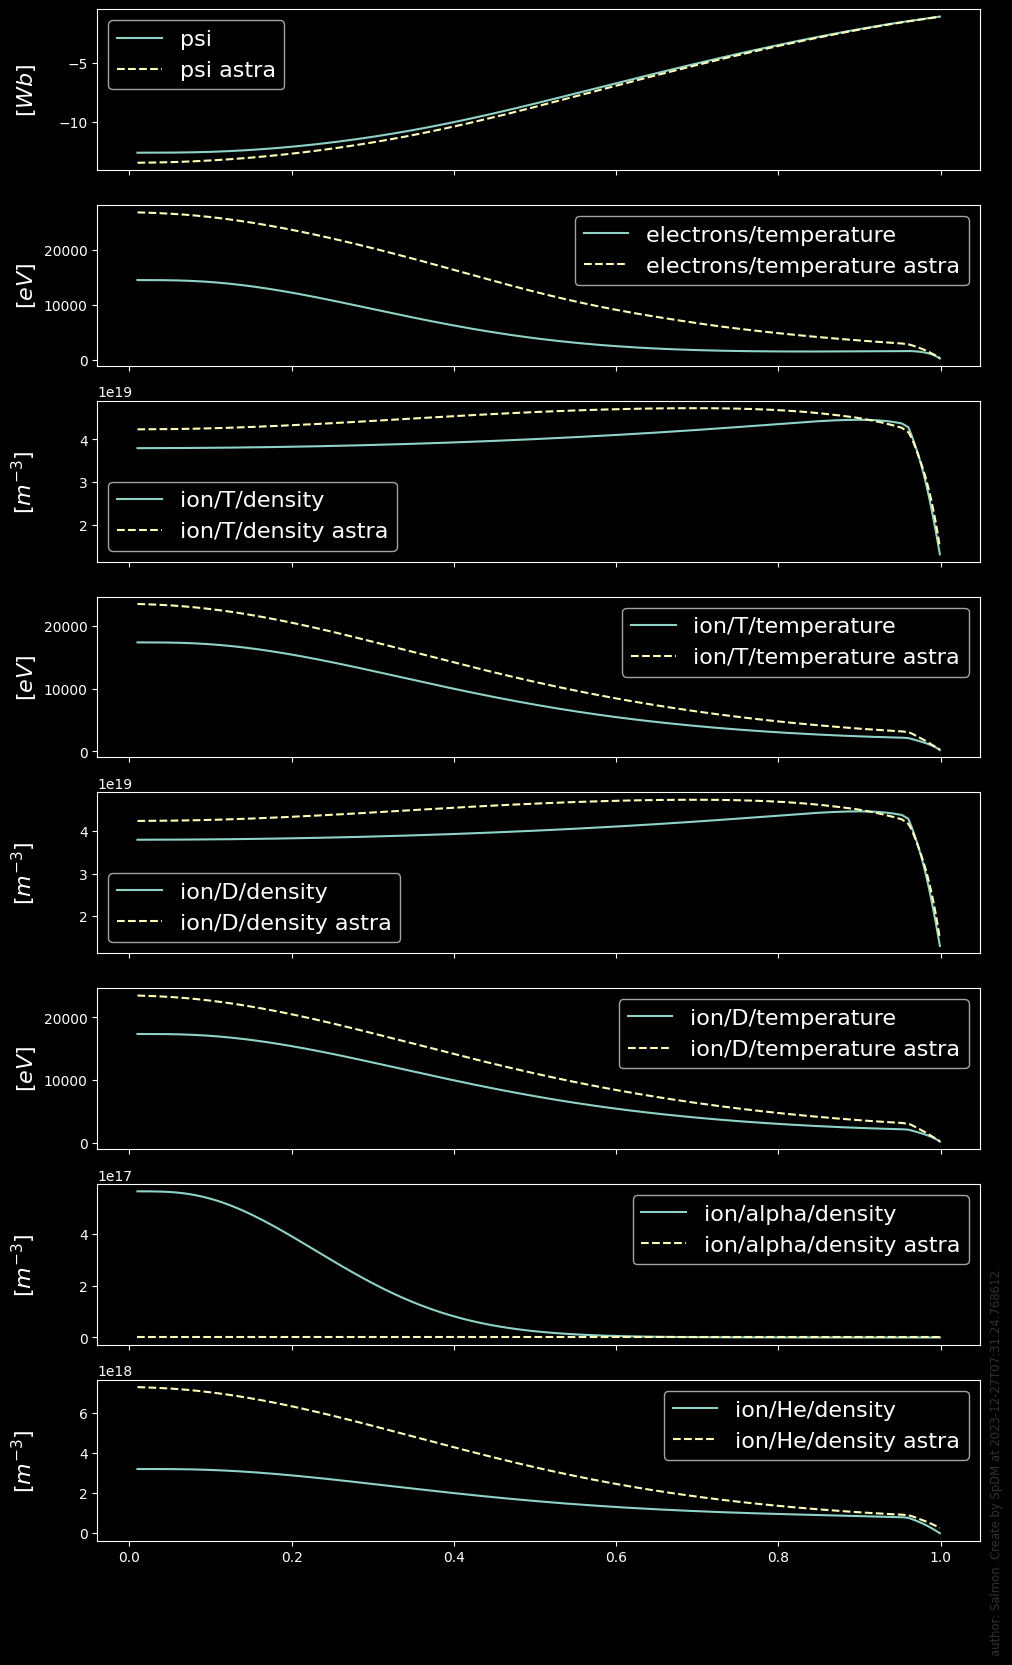

In [4]:
core_profiles_1d = tokamak.transport_solver.fetch()
core_profiles_1d_astra = tokamak.core_profiles.fetch().profiles_1d
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib":{"linestyle": "dashed"}},
            ),
            #    ( solver_1d.Y0[idx],equ.identifier)
        ]
        for equ in solver_1d.equations
    ],
)

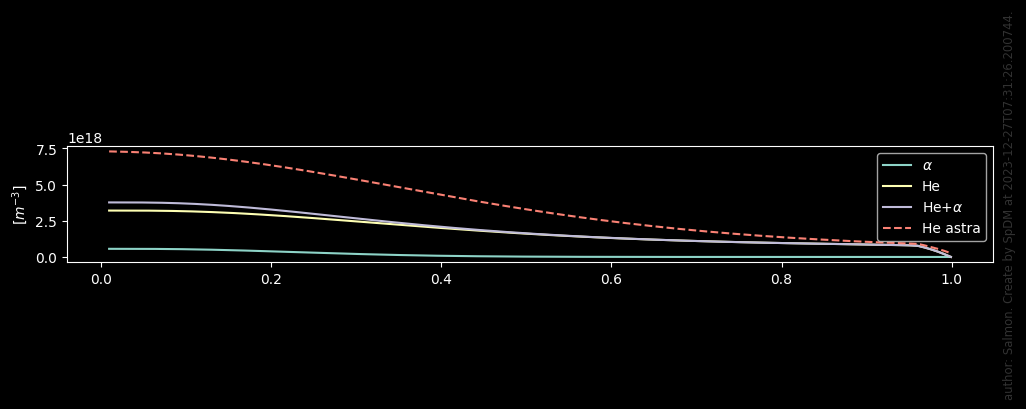

In [5]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["He"].density, r"He"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
        #    ( solver_1d.Y0[idx],equ.identifier)
    ],
    fontsize=10,
)

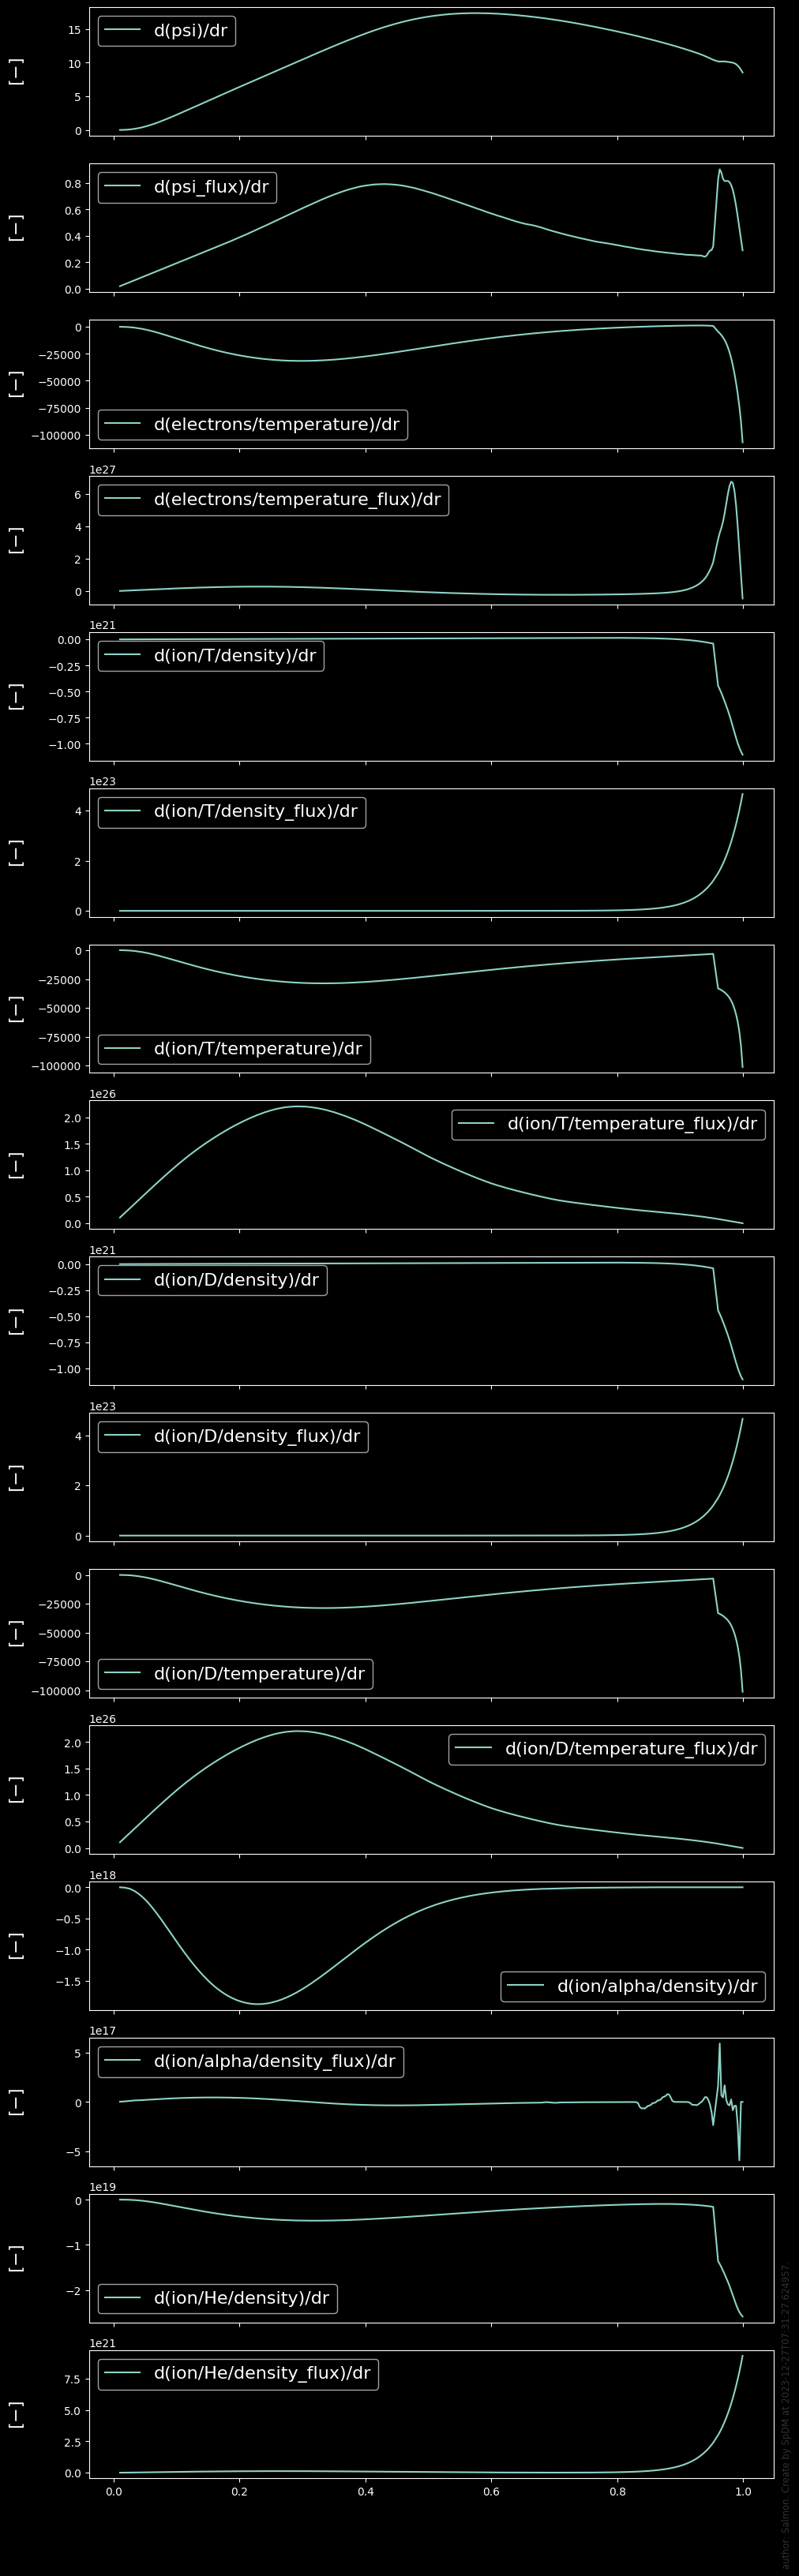

In [6]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

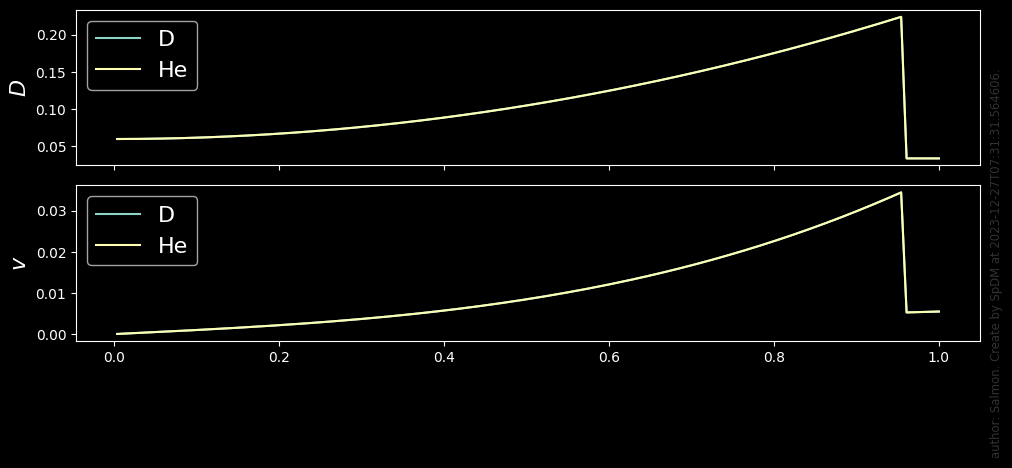

In [7]:
trans_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    (
        [
            (trans_1d.ion[0].particles.d, trans_1d.ion[0].label),
            (trans_1d.ion[2].particles.d, trans_1d.ion[2].label),
        ],
        {"y_label": "D"},
    ),
    (
        [
            (trans_1d.ion[0].particles.v, trans_1d.ion[0].label),
            (trans_1d.ion[2].particles.v, trans_1d.ion[2].label),
        ],
        {"y_label": "v"},
    ),
)

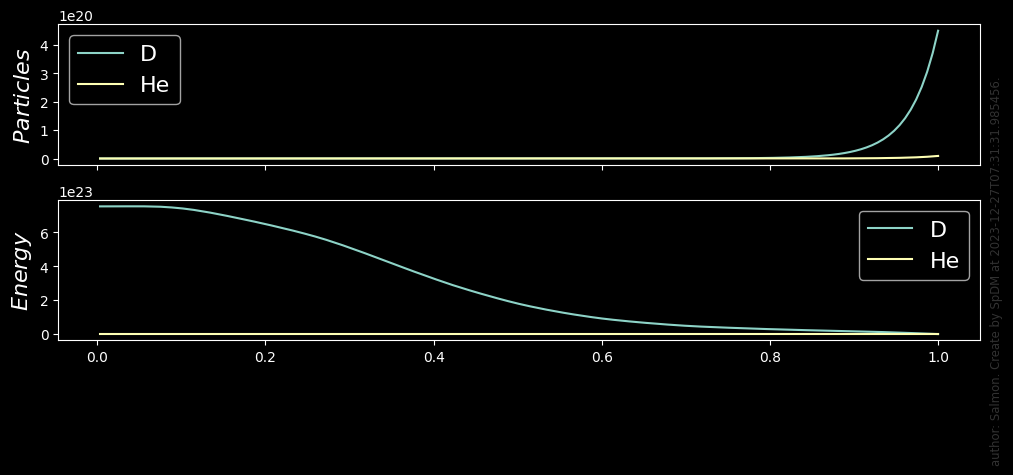

In [8]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        [
            (source_1d.ion[0].particles, source_1d.ion[0].label),
            (source_1d.ion[2].particles, source_1d.ion[2].label),
        ],
        {"y_label": "Particles"},
    ),
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)